In [9]:
import cv2
import numpy as np
from numba import njit, prange
from matplotlib import pyplot as plt

In [10]:
def add_noise(img, sigma):

    noise = np.random.normal(0, sigma, img.shape).astype(np.uint8)
    img += noise
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX, dtype=-1)

@njit(parallel=True, cache=True)
def cast_to_int(M):
    m, n = M.shape
    N = np.empty_like(M, dtype=np.int64)
    for i in prange(m):
        for j in prange(n):
            N[i, j] = int(np.round(M[i, j]))
    return N    

def calcDist(x, y, ref_pt):

    x -= ref_pt[0]
    y -= ref_pt[1]

def gen_ellipse(axes_length, nb_ellipses, img_shape, resize=False):

    m, n = img_shape
    img = np.zeros(img_shape, dtype=np.uint8)

    if nb_ellipses == 1:
        x_c, y_c = m//2, n//2
        img = cv2.ellipse(img, (x_c, y_c), axes_length, 0,
                          0, 360, (255,255,255), 3)

    else:
        for _ in range(nb_ellipses):
            fact = 1
            if resize:
                fact = np.random.uniform(0.8, 2)
            rotation = np.random.randint(0, 90)
            ax_h, ax_v = int(fact * axes_length[0]), int(fact * axes_length[1])

            x_c = np.random.randint(ax_h, m - ax_h, dtype=np.int)
            y_c = np.random.randint(ax_v, n - ax_v, dtype=np.int)

            img = cv2.ellipse(img, (x_c, y_c), (ax_h, ax_v),
                              rotation, 0, 360, (255,255,255), 3)
    return img

@njit
def pad(src, size):
    m, n = src.shape
    dst = np.zeros((m + 2 * size, n + 2 * size), dtype=np.uint8)
    dst[size:m + size, size:n + size] = src
    return dst

@njit
def increment(accum, indices, vec_x, vec_y):

    for i in indices:
        x, y = vec_x[i], vec_y[i]
        accum[x, y] += 1

def processImage(src, cannyLowThresh = 80, cannyHighThresh = 100):

    edges = cv2.Canny(src, cannyLowThresh, cannyHighThresh)
    x, y = np.nonzero(edges)

    dx = cv2.Sobel(src, cv2.CV_64F, 1, 0)
    dy = cv2.Sobel(src, cv2.CV_64F, 0, 1)
    angles =  (4 * np.degrees(np.arctan2(dy, dx))).astype(np.int16)
    
    # new_angles = np.empty_like(angles, dtype=np.float32)
    new_angles = angles / 4
    
    return x, y, new_angles[x, y]

def processTmpl(tmpl, ref_pt):
    """TODO: Create function to find center of mass for refPoint"""""
    m, n = tmpl.shape

    if ref_pt == (-1, -1):
        ref_pt = (m//2, n//2)

    x, y, phi = processImage(tmpl)

    calcDist(x, y, ref_pt)
    return x, y, phi

def processQuery(query, blur, sigma):

    if blur:
        query = cv2.GaussianBlur(query, (sigma, sigma), 0)

    x, y, phi = processImage(query)
    return x, y, phi

In [11]:
@njit
def find_maximas(src, grid_size):
    padded_src = pad(src, grid_size)
    x_maxs, y_maxs, values = [], [], []
    I, J = np.nonzero(padded_src)
    for i in range(len(I)):
        x, y = I[i], J[i]
        value = padded_src[x, y]

        grid = np.copy(padded_src[x-grid_size:x+grid_size+1, y-grid_size:y+grid_size + 1])
        grid[grid_size, grid_size] = 0

        if np.all(value >= grid):
            x -= grid_size
            y -= grid_size
            x_maxs.append(x)
            y_maxs.append(y)
            values.append(value)
    return x_maxs, y_maxs, values

@njit
def build_table(x, y, phi):
    r_table = {}
    thetas = np.arange(-180,180,0.25)
    for theta in thetas:
        indices = np.flatnonzero(phi == theta)
        if indices.any():
            r_table[theta] = np.vstack((x[indices], y[indices])).T
    return r_table


@njit
def build_accum(x, y, phi, r_table, shape):
    m, n = shape
    accum = np.zeros(shape, dtype=np.int64)

    for angle in r_table:
        entries = r_table[angle]
        sz = entries.shape[0]
        indices = np.flatnonzero(phi == angle)

        for i in range(sz):
            dx, dy = entries[i][0], entries[i][1]
            x_cand, y_cand = x[indices] + dx, y[indices] + dy
            cond = (0 <= x_cand) * (x_cand < m) * (0 <= y_cand) * (y_cand < n)
            valid_indices = np.flatnonzero(cond)
            increment(accum, valid_indices, x_cand, y_cand)

    return accum

In [12]:
@njit
def rotate_matrix(M, theta):
    theta = np.radians(theta)
    cos, sin = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([[cos, -sin], [sin, cos]])
    M = M.astype(np.float64) @ rotation_matrix
    return cast_to_int(M)


@njit
def get_keys(table):
    keys = []
    for _ in table:
        keys.append(_)
    return keys

@njit
def threshold_accum(src, factor=1):
    nb_pixels = len(np.nonzero(src)[0])
    if nb_pixels:
        thresh_value = factor * np.sum(src) // nb_pixels
        src = np.where(src > thresh_value, src, 0)
    return src

@njit
def rotate_table(table, theta):
    new_d = {}
    keys = get_keys(table) 
    for phi in np.arange(-180, 180, 0.25):
        new_angle = phi - theta
    
        if new_angle > 180:
            new_angle -= 360
            
        elif new_angle < -180:
            new_angle += 360
        
        if new_angle in keys:
            
            new_d[phi] = rotate_matrix(table[new_angle], theta)
        
    return new_d


@njit
def build_all_accums(pos_x, pos_y, pos_phi, table, shape, thresh = 3, grid_size=25):
    I, J, M = [], [], []
    for theta in np.arange(-180, 180, 0.25):
        new_table = rotate_table(table, theta)
        new_acc = build_accum(pos_x, pos_y, pos_phi, new_table, shape)
        new_acc = threshold_accum(new_acc, thresh)
        x, y, values = find_maximas(new_acc, grid_size)
        if x:
            I.append(x)
            J.append(y)
            M.append(values)        
    return I, J, M

In [13]:
axes_length = (80, 50)
shape = (700, 700)
noise_level = 0.4
nb_ellipses = 4

tmpl = gen_ellipse(axes_length, 1, shape)
query = gen_ellipse(axes_length, nb_ellipses, shape)
add_noise(query, noise_level)

In [14]:
I, J, Phi = processTmpl(tmpl, (-1, -1))
r_table = build_table(I, J, Phi)
I, J, Phi = processQuery(query, False, 3)
X, Y, V = build_all_accums(I, J, Phi, r_table, shape, 2, 25)
X = np.concatenate([np.array(i) for i in X])
Y = np.concatenate([np.array(i) for i in Y])
V = np.concatenate([np.array(i) for i in V])

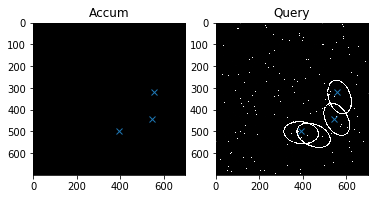

In [15]:
Accum = np.zeros(shape)

Accum[X, Y] = V

# Essayer un seuillage adaptif
Accum = threshold_accum(Accum, 8)

x_m, y_m, v_m = find_maximas(Accum, 50)

plt.subplot(1, 2, 1)
plt.title('Accum')
plt.imshow(Accum, cmap='gray')
plt.plot(y_m, x_m, 'x')

plt.subplot(1, 2, 2)
plt.title('Query')
plt.imshow(query, cmap='gray')
plt.plot(y_m, x_m, 'x')

In [24]:
@njit
def scale_rotate_matrix(M, theta, scale):
    theta = np.radians(theta)
    cos, sin = np.cos(theta), np.sin(theta)
    rotation_matrix = scale * np.array([[cos, -sin], [sin, cos]])
    M = M.astype(np.float64) @ rotation_matrix
    return cast_to_int(M)


@njit
def get_keys(table):
    keys = []
    for _ in table:
        keys.append(_)
    return keys

@njit
def threshold_accum(src, factor=1):
    nb_pixels = len(np.nonzero(src)[0])
    if nb_pixels:
        thresh_value = factor * np.sum(src) // nb_pixels
        src = np.where(src > thresh_value, src, 0)
    return src

@njit
def scale_rotate_table(table, theta, scale):
    new_d = {}
    keys = get_keys(table) 
    for phi in np.arange(-180, 180, 0.25):
        new_angle = phi - theta
    
        if new_angle > 180:
            new_angle -= 360
            
        elif new_angle < -180:
            new_angle += 360
        
        if new_angle in keys:
            
            new_d[phi] = scale_rotate_matrix(table[new_angle], theta, scale)
        
    return new_d


@njit
def build_all_accums(pos_x, pos_y, pos_phi, table, shape, thresh = 3, grid_size=25):
    I, J, M = [], [], []
    
    for theta in np.arange(-180, 180, 0.25):
        for s in np.arange(0.2, 5, 0.01):
            new_table = scale_rotate_table(table, theta, s)
            new_acc = build_accum(pos_x, pos_y, pos_phi, new_table, shape)
            new_acc = threshold_accum(new_acc, thresh)
        
            x, y, values = find_maximas(new_acc, grid_size)
            if x:
                I.append(x)
                J.append(y)
                M.append(values)        
    return I, J, M

In [25]:
axes_length = (80, 50)
shape = (700, 700)
noise_level = 0.4
nb_ellipses = 4

tmpl = gen_ellipse(axes_length, 1, shape)
query = gen_ellipse(axes_length, nb_ellipses, shape, resize=True)
add_noise(query, noise_level)

In [ ]:
I, J, Phi = processTmpl(tmpl, (-1, -1))
r_table = build_table(I, J, Phi)
I, J, Phi = processQuery(query, False, 3)
X, Y, V = build_all_accums(I, J, Phi, r_table, shape, 2, 25)
X = np.concatenate([np.array(i) for i in X])
Y = np.concatenate([np.array(i) for i in Y])
V = np.concatenate([np.array(i) for i in V])

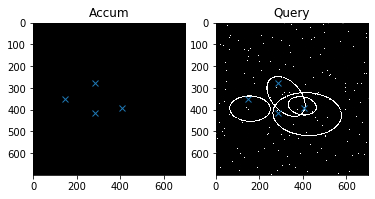

In [23]:
Accum = np.zeros(shape)

Accum[X, Y] = V

Accum = threshold_accum(Accum, 12)

x_m, y_m, v_m = find_maximas(Accum, 50)


plt.subplot(1, 2, 1)
plt.title('Accum')
plt.imshow(Accum, cmap='gray')
plt.plot(y_m, x_m, 'x')

plt.subplot(1, 2, 2)
plt.title('Query')
plt.imshow(query, cmap='gray')
plt.plot(y_m, x_m, 'x')